# Final Model Validation

### This notebook contains our final model trained against the entirety of the training set and validated against the testing set. To find our model testing and iterations, please consult the following links where we attempt various activation functions:

#### tanh:
#### softmax:
#### relu:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import seaborn as sns
import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models, layers, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Data Loading

#### Here we load the training and testing image sets from mendely. Since we have our final model from previous iterations, we will train the model against the entirety of the training set and validate it against the testing set.

In [2]:
train_data_dir = 'ZhangLabData/CellData/chest_xray/train'
test_data_dir = 'ZhangLabData/CellData/chest_xray/test'

#Get all the data in the directory data/validation (624 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
       test_data_dir, 
       target_size=(64, 64), batch_size=624, color_mode='grayscale', class_mode='binary')

#Get all the data in the directory data/train (5232 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
       train_data_dir, 
       target_size=(64, 64), batch_size=5232, color_mode='grayscale', class_mode='binary')

#Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


#### Labels for images

In [3]:
train_labels[:10]

array([0., 0., 1., 1., 1., 1., 0., 0., 0., 1.], dtype=float32)

In [4]:
test_labels[:10]

array([0., 1., 1., 1., 0., 0., 1., 0., 1., 0.], dtype=float32)

In [5]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

#### To ensure consistency with model iterations, we employed EarlyStoppping and ModelCheckpoint methods in the final model

In [6]:
#Earlystopping and Modelcheckpoint methods

early_stopping = [EarlyStopping(monitor='val_loss', patience=10), ModelCheckpoint(filepath='best_model.h5',
                                                                                 monitor='val_loss', save_best_only=True)]

#### Visualization function for loss function in model

In [7]:
#plot epochs vs loss and recall for train and test set
def visualize_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['test_loss', 'train_loss'])
    plt.title('Epochs vs Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show();
    
    plt.figure()
    plt.plot(history['val_recall'])
    plt.plot(history['recall'])
    plt.legend(['test_recall', 'train_recall'])
    plt.title('Epochs vs Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show();
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['test_acc', 'train_acc'])
    plt.title('Epochs vs Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show();

#### Final model creation

In [8]:
#CNN model
np.random.seed(42)
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3,3), activation='relu',
                        input_shape=(64, 64, 1)))

model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [9]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                7872576   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 7,872,961
Trainable params: 7,872,961
Non-trainable params: 0
_________________________________________________________________


#### For our compile method, we're examining recall and accuracy as our metrics. We are more concerned with false negatives than we are false positives when it comes to diagnosis, which is why recall is going to be our primary metric of evaluation. Accuracy ensures that our model makes the correct diagnosis consistently.

In [10]:
#Define optimizer with modified learning rate, compile, and fit to training data

optimizer = keras.optimizers.SGD(lr=0.0001)
model3.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(), 'acc'])

results3 = model3.fit(train_images,
                    train_labels,
                    callbacks=early_stopping,
                    epochs=10,
                    batch_size=128,
                    validation_data=(test_images, test_labels), shuffle=False)

Epoch 1/10
41/41 [==============================] - 5s 120ms/step - loss: 11.5257 - recall: 0.9490 - acc: 0.7521 - val_loss: 0.5039 - val_recall: 0.9256 - val_acc: 0.8189
Epoch 2/10
41/41 [==============================] - 5s 117ms/step - loss: 0.4945 - recall: 0.9794 - acc: 0.7576 - val_loss: 0.5852 - val_recall: 0.9974 - val_acc: 0.6506
Epoch 3/10
41/41 [==============================] - 5s 112ms/step - loss: 0.3987 - recall: 0.9724 - acc: 0.8276 - val_loss: 0.4134 - val_recall: 0.8769 - val_acc: 0.8381
Epoch 4/10
41/41 [==============================] - 5s 113ms/step - loss: 0.3551 - recall: 0.9531 - acc: 0.8547 - val_loss: 0.3984 - val_recall: 0.9282 - val_acc: 0.8365
Epoch 5/10
41/41 [==============================] - 5s 113ms/step - loss: 0.3330 - recall: 0.9384 - acc: 0.8641 - val_loss: 0.3562 - val_recall: 0.9103 - val_acc: 0.8622
Epoch 6/10
41/41 [==============================] - 5s 114ms/step - loss: 0.2969 - recall: 0.9395 - acc: 0.8765 - val_loss: 0.3335 - val_recall: 0.93

#### Model evaluation

In [11]:
results_train3 = model3.evaluate(train_images, train_labels)

164/164 [==============================] - 2s 12ms/step - loss: 0.1840 - recall: 0.9400 - acc: 0.9306


In [12]:
results_test3 = model3.evaluate(test_images, test_labels)

20/20 [==============================] - 0s 10ms/step - loss: 0.3130 - recall: 0.9462 - acc: 0.8718


#### Visualization of loss for training and test sets

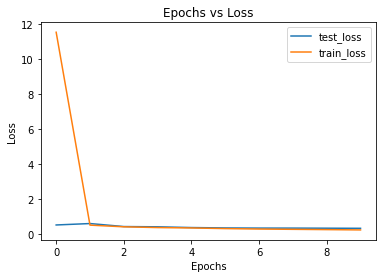

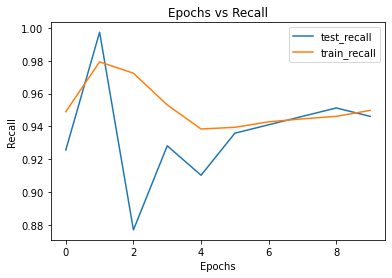

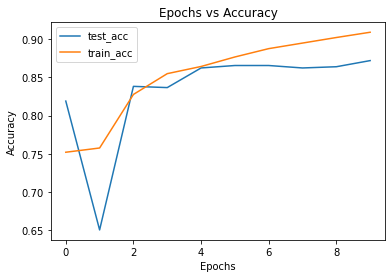

In [13]:
visualize_results(results3)

#### Insight: The variation in the curves is minimal, and the training and testing sets recall and loss curves between the  converge, indicating there is minimal overfitting. Therefore, we believe this is a good model for our prediction purposes.

#### Model predictions

In [14]:
#generating prediction variables, converting probabilities to 0 or 1 for confusion matrix

label_pred = (model3.predict(test_images) > 0.5).astype(int)

cf_matrix = confusion_matrix(test_labels, label_pred)

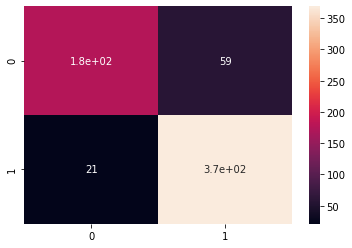

In [15]:
#heatmap of confusion matrix

sns.heatmap(cf_matrix, annot=True);

## SUMMARY

#### Here we display a model where the loss function between the train and testing sets are minimized, and makes predictions against unseen data with 87.2% accuracy. While these results are consistent, the data scientists working on this project are limited by their PC's computing power. Future work would increase the image sizes for greater resolution and therefore more accurate predictions. Additionally, having a larger data set would also benefit the model to perform with greater accuracy.